В этом занятии:

* Рассмотрим реализацию градиетного бустинга из библиотеки [XGBoost](https://xgboost.readthedocs.io/en/latest/python/index.html)

* Сравним качество прогнозов разных моделей между собой

* Увеличим точность классификации звезд

* Сможем лучше отличать кошку от собаки

* Научимся лучше прогнозировать стоимоcть автомобиля
___



Установим библиотеку _XGBoost_. Стоит также отметить, что алгоритмы, реализованные в _XGBoost_, совместимы с алгоритмами _sklearn_. На практике оказывается, что можно использовать функции из _XGBoost_ также как другие алгоритмы из _sklearn_ в единой связке.


In [ ]:
! pip install xgboost

Импортируем библиотеки

In [ ]:
import pandas as pd
import seaborn as sns
import sklearn.metrics as mk
import xgboost as xgb

# Градиентный бустинг - Классификация

## Данные


Мы будем использовать знакомый набор данных, а именно датасет с данными о [звездах](https://www.kaggle.com/datasets/deepu1109/star-dataset).
Необходимый СSV файл содержит набор данных из 240 звезд 6 классов:

* Коричневый карлик -> Тип звезды = 0

* Красный карлик -> Тип звезды = 1

* Белый карлик-> Тип звезды = 2

* Основная последовательность -> Тип звезды = 3

* Сверхгигант -> Тип звезды = 4

* Гипергигант -> Тип звезды = 5

**Наша цель - создать модель, которая поможет нам определять тип звезды на основе физических признаков, чтобы исследователи могли с помощью этой модели выполнять классификацию, без привлечения опытного астронома.**

In [ ]:
df = pd.read_csv("./star_set.csv")
df.head()

,Temperature (K),Luminosity(L/Lo),Radius(R/Ro),Absolute magnitude(Mv),Star type,Star color,Spectral Class
0,3068,0.002400,0.1700,16.12,0,Red,M
1,3042,0.000500,0.1542,16.60,0,Red,M
2,2600,0.000300,0.1020,18.70,0,Red,M
3,2800,0.000200,0.1600,16.65,0,Red,M
4,1939,0.000138,0.1030,20.06,0,Red,M


## Разбиение данных на обучающую и тестовую выборки

In [ ]:
features = pd.get_dummies(df.drop('Star type', axis=1), drop_first=True)
targets = df['Star type']

In [ ]:
from sklearn.model_selection import train_test_split
feat_train, feat_test, tar_train, tar_test = train_test_split(features, targets, test_size=0.77, random_state=40)

Перед использованием алгоритма, ознакомимся с его документацией привычной командой _help_.

In [ ]:
from xgboost import XGBClassifier
help(XGBClassifier)

Help on class XGBClassifier in module xgboost.sklearn:

class XGBClassifier(XGBModel, sklearn.base.ClassifierMixin)
 |  XGBClassifier(*, objective: Union[str, Callable[[numpy.ndarray, numpy.ndarray], Tuple[numpy.ndarray, numpy.ndarray]], NoneType] = 'binary:logistic', use_label_encoder: Optional[bool] = None, **kwargs: Any) -> None
 |  
 |  Implementation of the scikit-learn API for XGBoost classification.
 |  
 |  
 |  Parameters
 |  ----------
 |  
 |      n_estimators : int
 |          Number of boosting rounds.
 |  
 |      max_depth :  Optional[int]
 |          Maximum tree depth for base learners.
 |      max_leaves :
 |          Maximum number of leaves; 0 indicates no limit.
 |      max_bin :
 |          If using histogram-based algorithm, maximum number of bins per feature
 |      grow_policy :
 |          Tree growing policy. 0: favor splitting at nodes closest to the node, i.e. grow
 |          depth-wise. 1: favor splitting at nodes with highest loss change.
 |      learnin

Обучим модель.

In [ ]:
boost = XGBClassifier(random_state=40)
boost.fit(feat_train, tar_train)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, gpu_id=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=None, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              n_estimators=100, n_jobs=None, num_parallel_tree=None,
              objective='multi:softprob', predictor=None, ...)

Оценим точность классификации по взвешенной _f1-мере_

In [ ]:
preds = boost.predict(feat_test)
mk.f1_score(preds, tar_test, average="weighted")

0.9891705069124425

Рассмотрим подробнее матрицу классификации

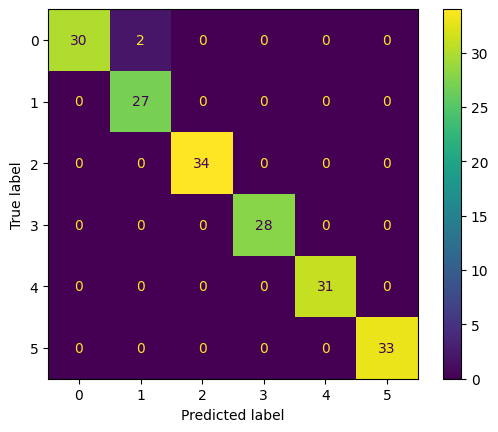

In [ ]:
from sklearn import metrics as mk
mk.ConfusionMatrixDisplay.from_estimator(boost, feat_test, tar_test);

Можно заметить, без оптимизации парамеров алгоритм показывает более высокую точность по сравнению с _RandomForestClassifier_ и _Decision Trees_

### **[Задание 1]**

Найдите два наиболее важных признака, согласно модели.

In [ ]:
# Решение

# Классификация кошек и собак

Вернемся к задаче классификации фотографий кошек и собак. Ниже представлен код для обработки изображений из более ранней практики.

In [ ]:
from sklearn.preprocessing import LabelEncoder
from IPython.display import Image, display
from imutils import paths

import cv2
import os

def get_hist(image, bins=(8, 8, 8)):
    hist = cv2.calcHist([image], [0, 1, 2], None, bins, [0, 256, 0, 256, 0, 256])
    cv2.normalize(hist, hist)
    return hist.flatten()

imagePaths = sorted(list(paths.list_images('train')))
data = []
labels = []

for (i, imagePath) in enumerate(imagePaths):
    image = cv2.imread(imagePath, 1)
    label = imagePath.split(os.path.sep)[-1].split(".")[0]
    hist = get_hist(image)
    data.append(hist)
    labels.append(label)

le = LabelEncoder()
labels = le.fit_transform(labels)

Разбиение набора данных на тестовую и обучающую выборки

In [ ]:
import numpy as np
feat_train, feat_test, tar_train, tar_test = train_test_split(np.array(data), labels, test_size=0.25, random_state=40)

Обучение модели

In [ ]:
model = XGBClassifier(random_state = 40)
model.fit(feat_train, tar_train)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, gpu_id=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=None, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              n_estimators=100, n_jobs=None, num_parallel_tree=None,
              predictor=None, random_state=40, ...)

Развернутая оценка точности классификации

In [ ]:
predictions = model.predict(feat_test)
print(mk.classification_report(tar_test, predictions))

              precision    recall  f1-score   support

           0       0.75      0.69      0.72        13
           1       0.69      0.75      0.72        12

    accuracy                           0.72        25
   macro avg       0.72      0.72      0.72        25
weighted avg       0.72      0.72      0.72        25



### **[Задание 2]**

Обучите модель на основе _SVC_ алгоритма при параметрах по умолчанию за исключением _random_state = 40_. Найдите разницу в значениях метрики *`f1_score`* между моделями основанными на _SVC_ и _XGBClassifier_.

In [ ]:
# Решение

### **[Задание 3]**

Определите, к какому классу отнесет модель, основанная на `XGBClassifier`, изображение `cat.12499.jpg`

In [ ]:
# Решение

# Градиентный бустинг - Регрессия

Градиентный бустинг можно использовать не только для классификации, но и регрессии. На основе [набора данных](https://www.kaggle.com/datasets/mayankpatel14/second-hand-used-cars-data-set-linear-regression) рассмотрим применение алгоритма.


**Наша цель - создать модель, которая поможет нам определять примерную стоимость собственного автомобиля на основе имеющейся информации без привлечения опытного оценщика**


Импорт данных

In [ ]:
df = pd.read_csv("./train.csv")
df = df.drop('v.id', axis=1)
df.head()

,on road old,on road now,years,km,rating,condition,economy,top speed,hp,torque,current price
0,535651,798186,3,78945,1,2,14,177,73,123,351318.0
1,591911,861056,6,117220,5,9,9,148,74,95,285001.5
2,686990,770762,2,132538,2,8,15,181,53,97,215386.0
3,573999,722381,4,101065,4,3,11,197,54,116,244295.5
4,691388,811335,6,61559,3,9,12,160,53,105,531114.5


Разбиение данных на обучающую и тестовую выборки

In [ ]:
from sklearn.model_selection import train_test_split

feature = df.drop("current price", axis=1)
target = df["current price"]

feat_train, feat_test, tar_train, tar_test = train_test_split(feature, target, test_size=0.3, random_state=40)

Обучаем модель

In [ ]:
from xgboost import XGBRegressor

boost_reg = XGBRegressor(random_state=40)
boost_reg.fit(feat_train, tar_train)

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, gpu_id=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=None, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             n_estimators=100, n_jobs=None, num_parallel_tree=None,
             predictor=None, random_state=40, ...)

Оценим модель через метрику `_r2_`

In [ ]:
prediction = boost_reg.predict(feat_test)
print(mk.r2_score(tar_test, prediction))

0.989166272014558


### **[Задание 4]**

Создайте еще одну регрессионную модель на основе `RandomForestRegressor` со значением `random_state=40` . Найдите, в сколько раз отличается значение метрики `MSE` моделей, основанных на `XGBRegressor` и `RandomForestRegressor` по тестовой выборке.

In [ ]:
# Решение